In [60]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd 

In [197]:
def tile_img(image, rows = 5, cols = 5):
    image = Image.fromarray(image)
    imgwidth, imgheight = image.size
    height = imgheight // rows
    width = imgwidth // cols
    tiles = [ ]
    for i in range(0, cols):
        for j in range(0, rows):
            box = (j * width, i * height, (j + 1) * width, (i + 1) * height)
            a = image.crop(box)
            tiles.append(np.array(a))
    return tiles 

def get_tiled_adj_lists(rows = 5, cols = 5):
    neighbor_sets = []
    for row in range(rows):
        for col in range(cols):
            neighbors = []
            for (x,y) in [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]: # (0,0) exlcuded
                if (0 <= (row + x) < rows) and (0 <= (col + y) < cols):
                    idx  = ((row + x) * cols) + col + y
                    neighbors.append(idx)
            neighbor_sets.append(neighbors)
    return neighbor_sets

def localize_corr_matrix(corr, num_images, rows, cols, include_self = False):
    adj_lists = get_tiled_adj_lists(rows, cols)
    nodes_per_img = rows * cols 

    localized_corr = np.ones_like(corr)

    for image in range(num_images):
        for block_idx, adj_list in zip(range(nodes_per_img), adj_lists):
            true_block_idx = block_idx + (nodes_per_img * image)
            true_adj_list = list(map(lambda x: x + (nodes_per_img * image), adj_list))
            localized_corr[true_block_idx] = np.mean(corr[true_adj_list], axis = 0)
    return localized_corr
def average_across_diagonal(a):
    return (a + a.T) / 2

# APL Smart Campus Multi-Camera Tracking Update
#### By: Nile Walker on 12/11/21
Where did I come from?
Weighted Correlation Aggregation for establishing regions of identity transfer across static multi camera systems

## Objective Recap:
* Given footage from multiple views throughout a scene, identify individuals traveling through the scene and maintain that identity across all available perspectives in which they appear.

## Assumptions:
* The footage is from static cameras.
* The real world overlap, positionings and calibrations of the cameras are not provided.
* The footage is synchronized such that frame n from any camera will represent roughly the same real world time as frame n from any other camera.
* Ground Truth multi camera track-lets are extremely limited and may not be available at all.

## Current Problem to Solve:
As an instance-level recognition problem, person re-ID faces two major challenges. First, the intra-class (instance/identity) variations are typically big due to the changes of camera viewing conditions. For instance, the view change across cameras (front to back) brings large appearance changes, making matching the same person difficult. Second, there are also small inter-class variations – people in public space often wear similar clothing; plus from a distance as is typically in surveillance videos, they can look incredibly similar.

Given this it would be useful if we could leverage the fact that we're observing a realtime surveillance system inorder to place additional constraints on which identities can be linked. And our assumptions provide several...
* Identities observed at the same time in the same camera cannot be the same person.
* Under most circumstances the likelihood that two seperate images contain the same person is inversely proportional to the amount of time that has passed since the most recent image was captured.
* Security cameras are often placed along passageways and common areas in such a way that the particular sequence of cameras that an individual might pass through is predictable.

While the first two are fairly simple to apply the last one requires that we either have some information on the real world placement/relationships of each of the cameras which according to our assumptions we don't. And without some multi camera tracks to train from we can't just observe which cameras people tend to reappear in. So in-order to get around this we need some unsupervised method to quantify which camera B, identities from camera A are likely to reappear in. 

## Current Solutions in Code:
So what I choose to do instead is leverage the fact that the footage is synchronized, and the relationship between motion in overlapping cameras will remain consistent over time if they stay in the same position and are observing the same real world object. So by looking at the correlated motion over time, we can build some idea of likely an object in camera A is related to an object in camera B. Then in order to better apply these associations to new identities we break the image into patches so that if only certain areas of the image overlap we don't build unwarranted correlations. 
<!-- Then by representing each patch as the average of its neighbors we better preserve the implicit correlations between nearby image patches. -->

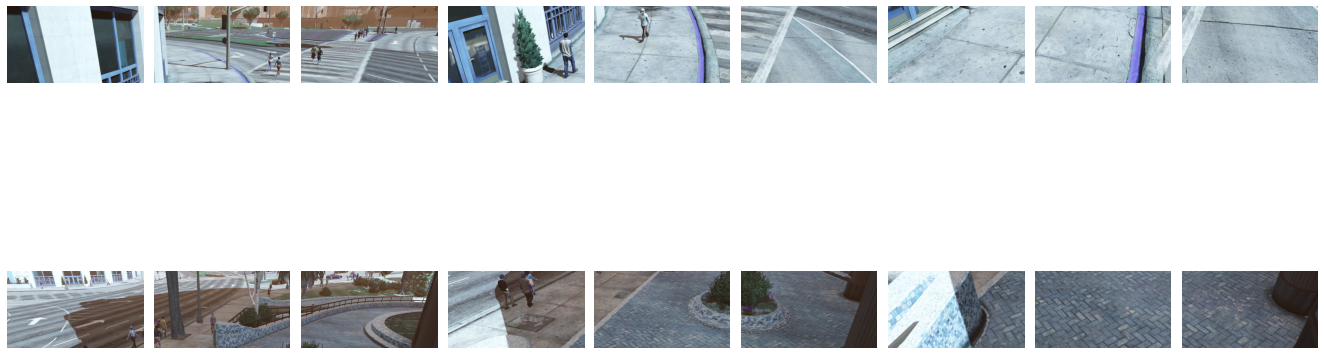

In [266]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
demo_ids = [4,5]
cameras = [cv2.VideoCapture(f"raw_data/videos/MTA_ext_short/train/cam_{cam_id}/cam_{cam_id}.mp4") for cam_id in demo_ids]

trows, tcols = 3,3

figure, axes = plt.subplots(nrows=len(demo_ids), ncols=trows * tcols)
figure.set_size_inches(18.5, 10.5, forward=True)
for row,feed in zip(axes,cameras):
    ret,img = [feed.read() for i in range(24)][-1]
    tiles = tile_img(img, trows, tcols)
    for col, img in zip(row, tiles):
        col.axis('off')
        col.imshow(img)

figure.tight_layout(h_pad = 0)

_ = [camera.release() for camera in cameras]

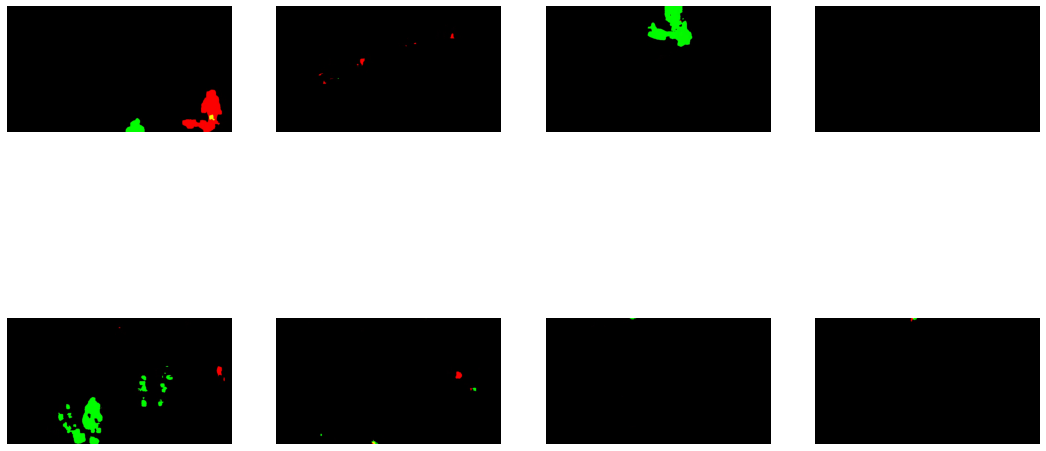

In [237]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
demo_ids = [4,5]
cameras = [cv2.VideoCapture(f"raw_data/videos/MTA_ext_short/train/cam_{cam_id}/cam_{cam_id}.flow.mp4") for cam_id in demo_ids]

trows, tcols = 2, 2 

fig = plt.figure()

fig.set_size_inches(18.5, 10.5, forward=True)
for i,feed in enumerate(cameras):
    ret,img = [feed.read() for i in range(24)][-1]
    tiles = tile_img(img, trows, tcols)
    for j, img in enumerate(tiles):
        ax = fig.add_subplot(len(demo_ids), trows * tcols, (i * (trows * tcols)) + (j + 1))
        plt.axis('off')
        plt.imshow(img)
_ = [camera.release() for camera in cameras]

At this stage every patch of a camera is treated as an individual sensor in which it provides a magnitude and a direction. After preprocessing to compute optical flow. I grabbed every 12th frame from a camera and then build out an array so that I can compute a correlation coefficient between each of the "sensors". At the same time I also compute corelations between the occupancy of each patch

In [241]:
cam_ids = [2, 3]

rows, cols = 6, 6

cameras = [cv2.VideoCapture(f"raw_data/videos/MTA_ext_short/train/cam_{cam_id}/cam_{cam_id}.mp4") for cam_id in cam_ids]

X_components = []
Y_components = []
Z_components = [] 

interval = 12
samples = 250 
running = True
while running and samples > 0: 
    samples -= 1
    X_components.append([])
    Y_components.append([])
    Z_components.append([])

    for i, feed in enumerate(cameras):
        ret, img = [feed.read() for _ in range(interval)][-1]
        if not ret or not running:
            running = False
            break

        tiles = tile_img(img, rows, cols)
        for tile in tiles:
            tile = tile.astype('float32')
            mag, ang = cv2.cartToPolar(tile[...,0], tile[...,1])
            tile[...,0], tile[...,1] = mag, ang
            avg_val_per_row = np.average(tile, axis=0)
            avg_val = np.average(avg_val_per_row, axis=0)
            X_components[-1].append(avg_val[0])
            Y_components[-1].append(avg_val[1])
            Z_components[-1].append(np.any(tile[tile > 0]))

# Generate occupancy measurse
X = np.array(X_components[:-1])
Y = np.array(Y_components[:-1])
Z = np.array(Z_components[:-1])

In [178]:
# Offset Measurements
image = 0

np.roll()

TypeError: _roll_dispatcher() missing 2 required positional arguments: 'a' and 'shift'

In [211]:
# Pandas Dataframes are better than numpy arrays at not producing nan values in the correlation matrix 
corr_X = np.nan_to_num(pd.DataFrame(X).corr().to_numpy())
corr_Y = np.nan_to_num(pd.DataFrame(Y).corr().to_numpy())

corr = (abs(corr_X) * .5) + (abs(corr_Y)* .5) 
for _ in range(1):
    corr = localize_corr_matrix(corr, len(cam_ids), rows, cols, include_self = False)
# Convert Image Patch Graph
corr = average_across_diagonal(corr)

In [216]:
corr

array([[0.39941397, 0.66373585, 0.56786106, ..., 0.43477668, 0.46169487,
        0.49556547],
       [0.66373585, 0.60477992, 0.70317348, ..., 0.46131434, 0.52183702,
        0.55394133],
       [0.56786106, 0.70317348, 0.62550515, ..., 0.56698205, 0.5773292 ,
        0.62242015],
       ...,
       [0.43477668, 0.46131434, 0.56698205, ..., 0.46476508, 0.59570268,
        0.59942975],
       [0.46169487, 0.52183702, 0.5773292 , ..., 0.59570268, 0.62142896,
        0.79192446],
       [0.49556547, 0.55394133, 0.62242015, ..., 0.59942975, 0.79192446,
        0.89382292]])

In [238]:
_ = [print(*localized_corr[i], sep = " ") for i in range(50)]

0.6041090673275521 0.665767371126983 0.6149689013425067 0.6159009722676182 0.525121705455793 0.6391413599930179 0.6812771942686687 0.6071130634376679 0.4245745910624679 0.32750963581589243 0.5722809301587602 0.5029688844002932 0.4825682866221987 0.36080367972661054 0.6123338347202253 0.608721551346559 0.6184337854422416 0.5052966933130544 0.46607594129752056 0.5067583137430658 0.3241570508187623 0.6109675282850615 0.6154959838699735 0.46766942529356276 0.5349984221013026 0.5763629058588103 0.5789247141267566 0.6082495443086732 0.521472263518881 0.5973631335277166 0.22571267519080418 0.39934177682525923 0.43300876264375776 0.618218960893953 0.367943502066778 0.09395017273551924 0.34502878790095637 0.45523794268929735 0.5776878353112158 0.54177216112399 0.20527842148163578 0.276426660167147 0.5383892192300169 0.6168843028980574 0.5614541777004102 0.4758473008055753 0.4954751980300351 0.4997684390031049 0.1945043722080686 0.5705880111301836
0.8514167335599996 0.48944276312392654 0.8614426

0.7162109560264328 0.4303445436818695 0.7227734518809632 0.7268719765900925 0.628346019844888 0.5843754456332942 0.5243406952754585 0.7159594813046213 0.5395444434516744 0.42924572907797953 0.6786173327902063 0.555953066457201 0.5246049552505944 0.45114794045636286 0.7201308333231025 0.7021933459349641 0.7261826345092335 0.5831736158316585 0.5438514152918708 0.5677376146985258 0.36597881658179887 0.7189138414481432 0.7249375233804323 0.4942496419965896 0.6002905325718374 0.6393290197006523 0.6853165914307721 0.7179574636594586 0.6541119621170273 0.6911397080122723 0.26729339789031303 0.45307923121780147 0.47096330908149325 0.7231697264335535 0.40218361013378534 0.1487399366464489 0.36769155947812304 0.482326943437831 0.7087509025960279 0.6381802622635042 0.2467958229959307 0.3106657404101595 0.5932660388137628 0.7264992918107496 0.6816576498446404 0.5762874776792994 0.5800470490176883 0.5880449903947568 0.30489252242010684 0.6865815947511742
0.7334040500254561 0.43689818560568067 0.735

[1] Ergys Ristani and Carlo Tomasi. Features for multi-target
multi-camera tracking and re-identification. In Proceedings of the IEEE conference on computer vision and pattern
[]